In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.samplers import CmaEsSampler, RandomSampler

import copy

# For reproducability
def set_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")


set_seed(50)

c:\Users\Abhay.Sharma\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
'''{ from google.colab import files
uploaded = files.upload()

! pip install tensorboard
! pip install optuna
! pip install optuna-integration[tensorboard]
 }'''

# ! pip install shap

'{ from google.colab import files\nuploaded = files.upload()\n\n! pip install tensorboard\n! pip install optuna\n! pip install optuna-integration[tensorboard]\n }'

#  Exploratory Data analysis

In [ ]:
# Converting the data into pandas dataframe
complete_data=pd.read_csv('Australian_Vehicle_Prices.csv')


print(f'Shape of data is {complete_data.shape}')

categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()

print(f'Categorical columns \n {categorical_cols}')
print(f'Numerical columns \n {numerical_cols}')

Shape of data is (16734, 19)
Categorical columns 
 ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats', 'Price']
Numerical columns 
 ['Year']


In [ ]:
# First few rows of the data
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [ ]:
# Missing cells
complete_data.isnull().sum().sort_values(ascending=False)

Seats                1705
Doors                1604
Location              450
BodyType              282
Car/Suv                28
Price                   3
Brand                   1
Model                   1
Year                    1
UsedOrNew               1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
CylindersinEngine       1
Kilometres              1
ColourExtInt            1
dtype: int64

# Visual CSV Data observations   
Some common observations-    
Some columns like kilometers, transmission, fuel are shown to having only few missing values but many values are fillled with symbols '-'.   
All vehicles with columns 'New available to order' have '-' in price instead of 0  
Some prices are filled with 'POA'



# Data cleaning & refinement

In [ ]:
# Fill NEW Available to order column with 0 kms
complete_data.loc[complete_data['Car/Suv'] == 'NEW Available to order', 'Kilometres'] = 0

# Converting into numeric columns
cols_to_convert = ['Kilometres','Price']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


# new list of categoric and numeric cols
categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()
print('Categorical cols-',categorical_cols)
print('Numerical cols-', numerical_cols)

# Missing cells
print('\nempty Cells-','\n',complete_data.isnull().sum().sort_values(ascending=False))

Categorical cols- ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats']
Numerical cols- ['Year', 'Kilometres', 'Price']

empty Cells- 
 Seats                1705
Doors                1604
Location              450
BodyType              282
Kilometres            156
Price                  53
Car/Suv                28
Model                   1
Year                    1
Brand                   1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
UsedOrNew               1
CylindersinEngine       1
ColourExtInt            1
dtype: int64


In [ ]:
complete_data.dropna(subset=['Price'], inplace=True)
complete_data.isnull().sum().sort_values(ascending=False)

print('Mean price-', complete_data['Price'].mean())
print('Max price-', complete_data['Price'].max())
print('Min price-', complete_data['Price'].min())


Mean price- 37303.33463221629
Max price- 1500000.0
Min price- 88.0


In [ ]:
# Outrliers check

from scipy import stats
complete_data = complete_data[complete_data['Price'] > 500]
z_scores = np.abs(stats.zscore(complete_data['Price']))
outliers = complete_data[z_scores > 10]
print(outliers)

               Brand    Year        Model                    Car/Suv  \
3036     Lamborghini  2019.0         Urus                        SUV   
3357         McLaren  2019.0         720S                Convertible   
3837   Mercedes-Benz  2023.0          G63             USED Dealer ad   
4046   Mercedes-Benz  2023.0          G63       Sydney Luxury Motors   
5271         Ferrari  2019.0         GTC4                      Coupe   
5502         Bentley  2020.0  Continental  Lorbek Luxury Cars Sydney   
10358    Lamborghini  2012.0    Aventador                      Coupe   
14924        Bentley  2023.0  Continental     NEW Available to order   
14932        Bentley  2023.0  Continental     NEW Available to order   
14943        Bentley  2023.0  Continental     NEW Available to order   
15053        McLaren  2023.0        600LT     NEW Available to order   
15079          Aston  2023.0       Martin     NEW Available to order   
15098        McLaren  2023.0         720S     NEW Available to o

In [ ]:
#  Converting some columns form large categorical sets to nummeric

complete_data['Engine_capacity']=complete_data['Engine'].str.split(',').str[1]
complete_data['Engine_capacity'] = complete_data['Engine_capacity'].str.replace(' L', '', regex=False)

complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()
complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()

complete_data[['City', 'State']] = complete_data['Location'].str.split(',', expand=True)

complete_data['CylindersinEngine'] =complete_data['CylindersinEngine'].str.split().str[0]
complete_data['Doors'] =complete_data['Doors'].str.split().str[0]
complete_data['Seats'] =complete_data['Seats'].str.split().str[0]

cols_to_convert = ['Engine_capacity','FuelConsumption','Doors','Seats']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# unique values in each column
print('Unique values in each column','\n', complete_data.nunique())

Unique values in each column 
 Brand                   76
Year                    45
Model                  781
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Price                 3792
Engine_capacity         65
City                   606
State                    9
dtype: int64


In [ ]:
complete_data['Price'] = complete_data[['Price']].astype(int)
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,...,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price,Engine_capacity,City,State
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,...,White / Black,"Caringbah, NSW",4,SUV,4.0,7.0,51990,2.2,Caringbah,NSW
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,...,Black / Black,"Brookvale, NSW",4,Hatchback,5.0,5.0,19990,1.5,Brookvale,NSW
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,...,Grey / White,"Sylvania, NSW",4,Coupe,2.0,4.0,108988,2.0,Sylvania,NSW
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,...,White / Brown,"Mount Druitt, NSW",8,Coupe,2.0,4.0,32990,5.5,Mount Druitt,NSW
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,...,Grey / Black,"Castle Hill, NSW",4,SUV,4.0,5.0,34990,1.3,Castle Hill,NSW


In [ ]:
complete_data.isnull().sum().sort_values(ascending=False)

Engine_capacity      1766
Seats                1688
FuelConsumption      1681
Doors                1587
Location              449
City                  449
State                 449
BodyType              279
Kilometres            139
Car/Suv                26
Brand                   0
Title                   0
Model                   0
Year                    0
UsedOrNew               0
ColourExtInt            0
DriveType               0
FuelType                0
Transmission            0
Engine                  0
CylindersinEngine       0
Price                   0
dtype: int64

# Seperating training and test data

In [ ]:
# Extract last 1000 rows into a new DataFrame
Test_data = complete_data.tail(1000).copy()
y_actual_test=Test_data['Price'].astype(int)

# Remove last 1000 rows from the original DataFrame
Training_data= complete_data.iloc[:-1000]
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']

# Mutual information chart for feature importance

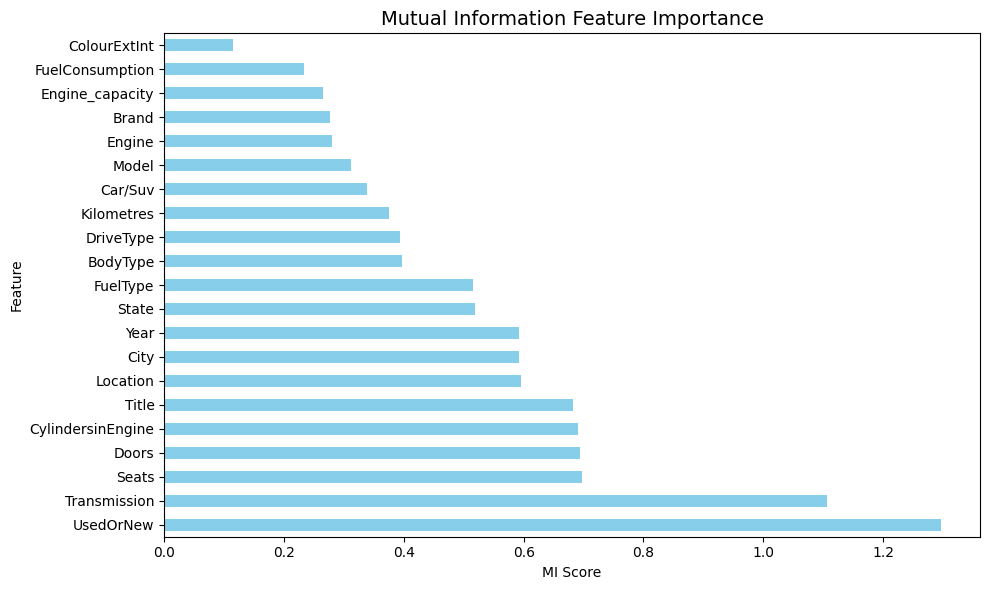

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Calculating mi scores
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X.fillna(0, inplace=True)

mi = mutual_info_classif(X, y,random_state=50)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Plotting mi scores
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh', color='skyblue')
plt.title("Mutual Information Feature Importance", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Return to original x and y
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']


# Data splitting into training and validation data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=50)

categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() <= 800 and  (X_train_full[cname].dtype == "object" or X_train_full[cname].dtype.name == "category")]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)])

X_train_pre = preprocessor.fit_transform(X_train_full)
X_valid_pre = preprocessor.transform(X_valid_full)
X_test_pre = preprocessor.transform(Test_data)


In [ ]:
num_features = numerical_cols

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)

feature_names = list(num_features) + list(cat_features)
print(feature_names)

['Year', 'FuelConsumption', 'Kilometres', 'Doors', 'Seats', 'Engine_capacity', 'Brand_Abarth', 'Brand_Alfa', 'Brand_Aston', 'Brand_Audi', 'Brand_BMW', 'Brand_BYD', 'Brand_Bentley', 'Brand_Caterham', 'Brand_Chery', 'Brand_Chevrolet', 'Brand_Chrysler', 'Brand_Citroen', 'Brand_Cupra', 'Brand_Daihatsu', 'Brand_Dodge', 'Brand_FPV', 'Brand_Ferrari', 'Brand_Fiat', 'Brand_Ford', 'Brand_Foton', 'Brand_GWM', 'Brand_Geely', 'Brand_Genesis', 'Brand_Great', 'Brand_HSV', 'Brand_Haval', 'Brand_Hino', 'Brand_Holden', 'Brand_Honda', 'Brand_Hummer', 'Brand_Hyundai', 'Brand_Ineos', 'Brand_Infiniti', 'Brand_International', 'Brand_Isuzu', 'Brand_Iveco', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Kia', 'Brand_LDV', 'Brand_Lamborghini', 'Brand_Land', 'Brand_Lexus', 'Brand_Lotus', 'Brand_MG', 'Brand_Mahindra', 'Brand_Maserati', 'Brand_Mazda', 'Brand_McLaren', 'Brand_Mercedes-Benz', 'Brand_Mini', 'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand_Proton', 'Br

# Pytorch model

In [ ]:
total_epochs=400

X_train_tensor=torch.tensor(X_train_pre.todense(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
dataset=TensorDataset(X_train_tensor,y_train_tensor)

X_valid_tensor=torch.tensor(X_valid_pre.todense(), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
if y_valid_tensor.dim() == 1:
    y_valid_tensor = y_valid_tensor.unsqueeze(1)

X_test_tensor=torch.tensor(X_test_pre.todense(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_actual_test.values, dtype=torch.float32)
if y_test_tensor.dim() == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)


class Regressor(nn.Module):
    torch.manual_seed(50)
    def __init__(self, input_dim, units,num_layers):
        super().__init__()
        layers=[]
        in_dim=input_dim


        for i in range(num_layers):
            out_dim=units*2**(num_layers-(i+1))
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_dim=out_dim
        layers.append(nn.Linear(in_dim,1))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

# Hyperparameter tuning

In [ ]:
def objective(trial):
    set_seed(50)

    # Early stopping
    patience=20
    min_delta=10
    best_valid_loss=float('inf')
    epochs_no_improve=0
    best_model_state = None

    num_layers=trial.suggest_int('num_layers',3,6)
    units = trial.suggest_int('units', 800, 1000)
    batch_size = trial.suggest_int('batch_size', 500, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01)


    model = Regressor(input_dim=X_train_pre.shape[1], units=units,num_layers=num_layers)
    criterion=nn.L1Loss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)


    log_dir = f"runs_{timestamp}/fit/Trial_{trial.number}"
    writer=SummaryWriter(log_dir)


    loader=DataLoader(dataset, batch_size=batch_size, shuffle=True,  worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50),num_workers=0)

    #Train the model
    for epoch in range(total_epochs):
        model.train()
        train_loss = 0
        total_samples = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred=model(X_batch)
            loss=criterion(y_pred,y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
        train_loss = train_loss / total_samples

        model.eval()
        with torch.inference_mode():
            y_pred_valid = model(X_valid_tensor)
            valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))
            writer.add_scalars('Loss', {'Train': train_loss,'Valid': valid_loss}, epoch)

        print(f'{epoch+1}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

        if (best_valid_loss-valid_loss)>min_delta:
            best_valid_loss=valid_loss
            epochs_no_improve=0
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch=epoch
        else:
            epochs_no_improve+=1
            if epochs_no_improve>=patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_valid_loss:.4f} at epoch {best_epoch} \n")

    writer.add_scalar('Parameters/Units', units, trial.number)
    writer.add_scalar('Parameters/Batch_size', batch_size, trial.number)
    writer.add_scalar('Parameters/Learning_rate', learning_rate, trial.number)
    writer.add_scalar('Parameters/Num_layers', num_layers, trial.number)
    writer.add_scalar('Loss/Train_loss', train_loss, trial.number)
    writer.add_scalar('Loss/Valid_loss', valid_loss, trial.number)


    writer.close()

    return best_valid_loss


In [ ]:
set_seed(50)

study = optuna.create_study(direction="minimize",study_name="Hyperparametr optimization with pytorch",sampler=optuna.samplers.TPESampler(seed=50))
study.optimize(objective, n_trials=5)

[I 2025-08-04 08:44:48,335] A new study created in memory with name: Hyperparametr optimization with pytorch


1/400 Train loss-36926.970801995725 Valid loss-37761.953125
2/400 Train loss-36867.54248109156 Valid loss-37686.18359375
3/400 Train loss-36780.71777904277 Valid loss-37575.984375
4/400 Train loss-36660.29233442034 Valid loss-37422.703125
5/400 Train loss-36500.762134162745 Valid loss-37241.19921875
6/400 Train loss-36299.31984446 Valid loss-37016.4765625
7/400 Train loss-36056.821131803554 Valid loss-36747.375
8/400 Train loss-35766.99161078005 Valid loss-36475.859375
9/400 Train loss-35414.28803019621 Valid loss-36152.47265625
10/400 Train loss-34931.46042321653 Valid loss-35515.89453125
11/400 Train loss-34412.269611436495 Valid loss-35115.8828125
12/400 Train loss-33854.160440561725 Valid loss-34446.015625
13/400 Train loss-33258.00294946165 Valid loss-33758.296875
14/400 Train loss-32608.163297069317 Valid loss-33110.73046875
15/400 Train loss-31909.8483178275 Valid loss-32358.15625
16/400 Train loss-31167.63070351737 Valid loss-31597.900390625
17/400 Train loss-30382.067853032328

[W 2025-08-04 09:19:59,601] Trial 0 failed with parameters: {'num_layers': 4, 'units': 891, 'batch_size': 627, 'learning_rate': 0.004566969187504993} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Abhay.Sharma\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_11004\3656551943.py", line 45, in objective
    y_pred_valid = model(X_valid_tensor)
  File "c:\Users\Abhay.Sharma\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\Users\Abhay.Sharma\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
  File "C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_11004\13153

KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

Best hyperparameters: {'num_layers': 3, 'units': 200, 'batch_size': 704, 'learning_rate': 0.007947045953557424}
Best validation loss: 5518.80859375


# Building the model with tuned hyperparameters

In [ ]:
set_seed(50)


best_params = study.best_params

model = Regressor(input_dim=X_train_pre.shape[1],
                    units=best_params['units'],
                    num_layers=best_params['num_layers'])

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True,    worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50))

patience = 20
min_delta = 10
best_valid_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(total_epochs):
    model.train()
    total_loss = 0
    total_samples = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        total_samples += X_batch.size(0)

    train_loss = total_loss / total_samples

    model.eval()
    with torch.inference_mode():
        y_pred_valid = model(X_valid_tensor)
        valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))

    print(f'{epoch+1}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

    if (best_valid_loss - valid_loss) > min_delta:
        best_valid_loss = valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

model.load_state_dict(best_model_state)

1/400 Train loss-36940.049007493624 Valid loss-37791.09375
2/400 Train loss-36917.426678093114 Valid loss-37756.16015625
3/400 Train loss-36880.69007095025 Valid loss-37714.96484375
4/400 Train loss-36826.873026945155 Valid loss-37652.19140625
5/400 Train loss-36753.30285395408 Valid loss-37566.453125
6/400 Train loss-36658.8926179847 Valid loss-37453.8125
7/400 Train loss-36542.07318239796 Valid loss-37328.00390625
8/400 Train loss-36401.074238679845 Valid loss-37162.9453125
9/400 Train loss-36224.406070631376 Valid loss-36967.28515625
10/400 Train loss-36009.62073501275 Valid loss-36852.375
11/400 Train loss-35751.12298708546 Valid loss-36461.37890625
12/400 Train loss-35454.42819276148 Valid loss-36118.078125
13/400 Train loss-35133.752680564416 Valid loss-35763.21875
14/400 Train loss-34786.153140943876 Valid loss-35423.99609375
15/400 Train loss-34415.027782206635 Valid loss-35038.48828125
16/400 Train loss-34018.71983617666 Valid loss-34638.64453125
17/400 Train loss-33599.904007

<All keys matched successfully>

# Predicting on test data

In [ ]:
import shap

set_seed(50)

model.eval()
with torch.no_grad():
    y_pred_test =model(X_test_tensor)

y_pred_test = y_pred_test.flatten()
Prediction=pd.Series(y_pred_test.tolist())
Prediction.name = 'Predicted Price'
Prediction=pd.DataFrame(Prediction)
Prediction['Predicted Price'] = Prediction['Predicted Price'].astype(int)
print(Prediction)

     Predicted Price
0              17715
1              34178
2              14213
3              25497
4              34231
..               ...
995            33314
996            54832
997            33915
998            46624
999            41318

[1000 rows x 1 columns]


# Recording and saving outputs

In [ ]:
from sklearn.metrics import mean_absolute_error

y_actual_test.name = 'Actual Price'
y_actual_test=pd.DataFrame(y_actual_test)

Test_data['Actual Price']=y_actual_test['Actual Price'].values
Test_data['Predicted Price']=Prediction['Predicted Price'].values
Test_data = Test_data.drop('Price',axis=1)
mae = mean_absolute_error(y_actual_test, y_pred_test)
print(f"Test MAE: {mae:.4f}")
Test_data.to_csv('Final_results.csv', index=True)

Test MAE: 7116.8375


PermutationExplainer explainer: 1001it [25:10,  1.52s/it]                          
C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_30216\2377921433.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)


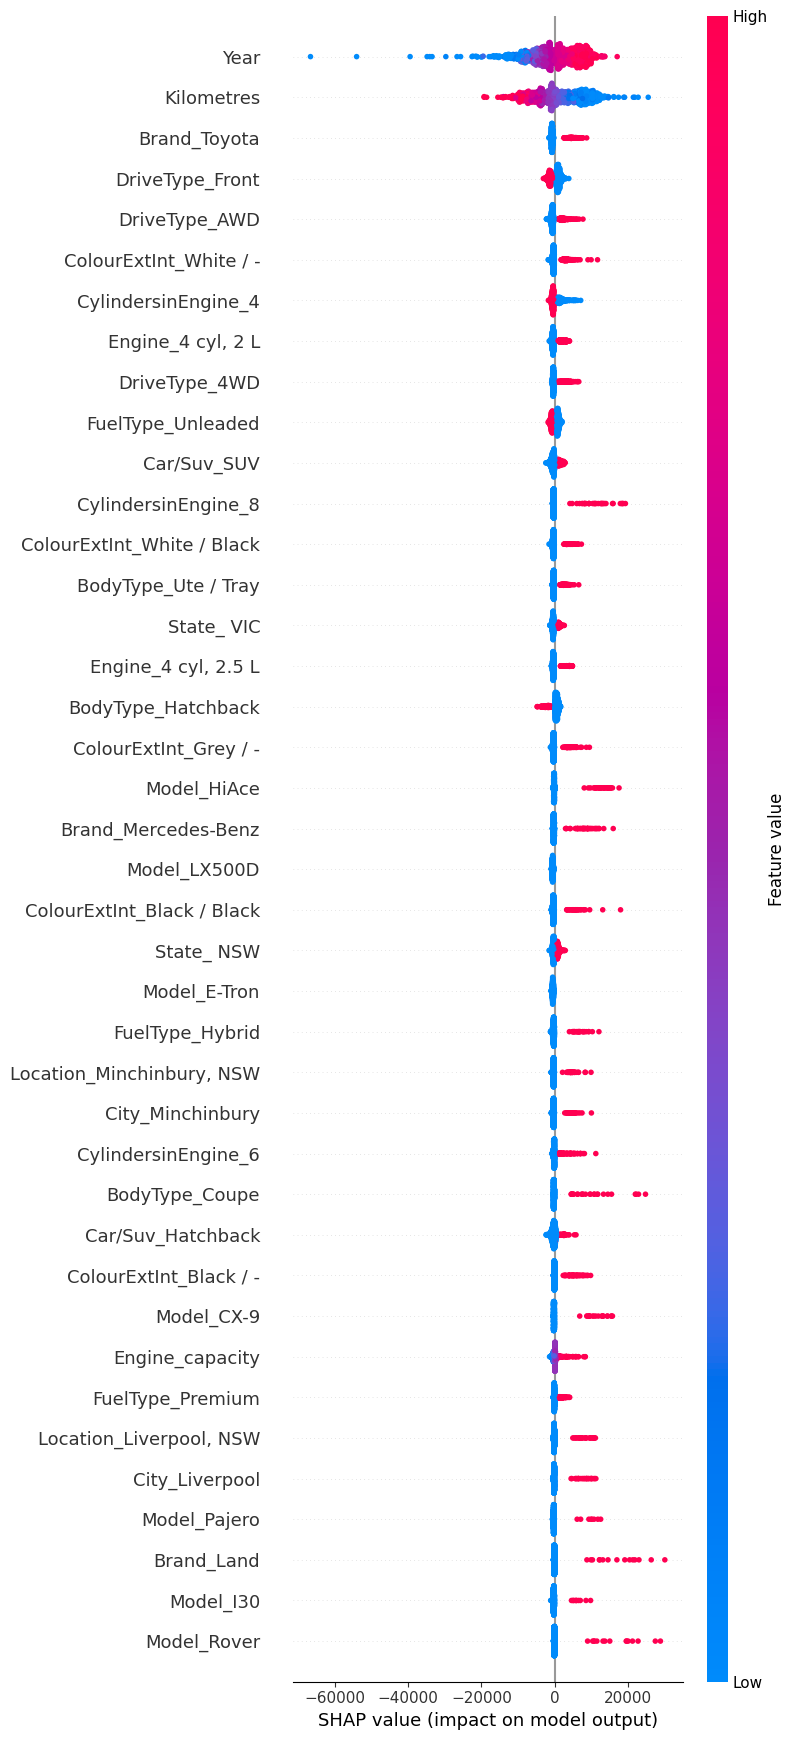

In [ ]:
from io import BytesIO
import numpy as np
from PIL import Image

def plot_pred_vs_actual(y_actual_test, y_pred_test):
    plt.figure(figsize=(6,6))
    plt.scatter(y_actual_test, y_pred_test, alpha=0.6)
    plt.plot([y_actual_test.min(), y_actual_test.max()], [y_actual_test.min(), y_actual_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    return plt.gcf()


def plot_residuals(y_actual_test, y_pred_test):
    residuals = y_pred_test - y_actual_test
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.hlines(0, min(y_pred_test), max(y_pred_test), colors='red', linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    return plt.gcf()

# Convert tensors to NumPy
X_train_np = X_train_tensor.detach().cpu().numpy()
X_test_np = X_test_tensor.detach().cpu().numpy()

explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
shap_values = explainer(X_test_np,max_evals=800)
shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)
fig_shap = plt.gcf()
# Convert plot to image tensor
buf = BytesIO()
fig_shap.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
img = Image.open(buf).convert("RGB")
img = np.array(img).transpose(2, 0, 1)  # Convert to (C, H, W)

writer = SummaryWriter(f"runs_{timestamp}/Predictions")

fig1 = plot_pred_vs_actual(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Predicted vs Actual", fig1, global_step=0)

fig2 = plot_residuals(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Residual Plot", fig2, global_step=0)

writer.add_image("SHAP Summary", img, global_step=0 )

writer.close()

In [ ]:
shap.initjs()

explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
single_instance = X_test_np[[308]]  # shape: (1, n_features)
explanation = explainer(single_instance,max_evals=800)
# Convert float32s to float64 or Python float
base_value=explanation.base_values[0].item()
shap_values = explanation.values[0].astype(float)
feature_values = single_instance[0].astype(float)

# Plot the force plot
shap.plots.force(base_value, shap_values, feature_values,feature_names=feature_names,)




# Model parameters summary

In [ ]:
print(model)
from torchinfo import summary
summary(model)

Regressor(
  (net): Sequential(
    (0): Linear(in_features=3280, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=800, out_features=400, bias=True)
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=400, out_features=200, bias=True)
    (9): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=200, out_features=1, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Regressor                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       2,624,800
│    └─BatchNorm1d: 2-2                  1,600
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       320,400
│    └─BatchNorm1d: 2-6                  800
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       80,200
│    └─BatchNorm1d: 2-10                 400
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      201
Total params: 3,028,401
Trainable params: 3,028,401
Non-trainable params: 0